# Bird classification with transfer learning

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob, os
import skimage.io
from datetime import datetime
import seaborn as sns

In [3]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomUniform

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Activation, add, concatenate, LeakyReLU


from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as ppu # in order not to overwrite the IRNV2 preprocess_input

### Abstract

Transfer learning is a subfield of deep learning which utilizes the knowledge gained from a source task to solve another task which usually is related and somehow similar to the first. Classification of birds from images is a fine-grained scientific problem that can be difficult to solve due to scarcity of data and similarity between bird species. This project examines several different models that are trained on a small dataset containing images of 14 species of birds. Three of the models are based on transfer learning and utilize pre-trained on the ImageNet dataset convolutional neural network architectures, such as VGG16 and Inception-ResNet, which contain residual and inception blocks. Two additional models are also implemented in order to compare their performance on a small dataset with that of pre-trained models. The whole feature extraction parts of both transferred models have their weights frozen because the classification task is similar to the source one. Model performance is evaluated through an additional set of validation images, as well as several pictures of birds some of which are stretched or shrunk during resizing. In order to boost learning, data augmentation is applied using the ImageDataGenerator class in Keras.

### Introduction

*Bird classification*

The number and type of bird species in a given area is an accurate indicator of biodiversity and their recognition is an important undertaking for environmentalists and zoologists. On the other hand, bird taxonomy is a constantly evolving scientific field, and given the huge number of bird species, their classification is not a trivial task even for professionals. Bird classification is a fine-grained categorization problem that refers to the recognition of closely related entities such as dog breeds and flower species classification. Bird classification with artificial neural networks can be very challenging due to difference in bird pose, whether in flight or sitting on a branch, location in the image, light conditions, variations in background, presence of objects concealing parts of the bird such as branches, leaves and grass, prevalent sexual and age dimorphism in birds,  and others [1].

*Transfer learning*

Transfer learning refers to implementing the knowledge that an artificial neural network has acquired from a source task to a new task that is sufficiently similar to the first one. The biggest benefit of transfer learning shows when the data for a deep learning task is insufficient and data augmentation is incapable of solving the problem. Transfer learning is most helpful when the dataset for the initial task is much larger than the data available for the destination task [2].<br>

Depending on the size of the dataset available for training and its similarity to the dataset used for training the pre-trained model, the latter can be used for feature extraction or for classification.


* Pre-trained model as classificator. For small datasets that are also similar to the initial, the whole architecture of the pre-trained model can be kept with the weights trained on the initial dataset frozen. Usually, the top fully connected layer is replaced with another classification layer depending on the number of classes to be classified.

* Pre-trained model as a feature extractor. For large enough datasets only part of the pre-trained model can be reused and the other weights retrained while fine-tuning the model. It is a usual practice to re-use the first part of the convolutional layers of the pre-trained model and re-train the weights of the deeper ones. This is motivated by the observation that the initial layers learn more general features in the images such as lines and curves, and going deeper in the neural network - more abstract patterns are processed [3].  


*Data augmentation*

Data augmentation is a technique to create new training data by transformations of the already existing data such as shifts, flips, rotations, zooming, change of exposure, and others. It is a necessary step when the data is insufficient, is mostly applied to training data, and intends to create meaningful data examples. Although convolutional neural networks (CNN) learn invariant to the location in the image features, augmentation can further aid the model in learning features that are also invariant to transforms such as left-to-right to top-to-bottom ordering, light levels in photographs, and more [4].




### Related work

The bottleneck in the present deep learning task is the small size of the data available for training. Although there is a large amount of bird images on the net, there are many bird species that are rarely seen and photographed. There are many investigations related to implementation of transfer learning for image classification but few of them are dedicated to pretrained model reuse for fine-grained problems such as bird classification, that are at the same time prone to lack of data and other problems with wildlife photography mentioned above. The authors of [1] have proposed a method to both localize and classify the bird species from high-definition photographs and have found out that transfer learning is improving both accuracy measurement and convergence of their model with the Inception ResNet V2 model achieving the best result.
The authors of [9] have also demonstrated the effectiveness of transfer-learning for fine-grained classification, this time for food recognition. Model comparison performed by the authors of [10] on a small set of bird images show better accuracy results for VGG compared to ResNet18.

### Data and architecture

The dataset used in this project consists of bird images collected during birdwatching in Bulgaria. There are 14 bird species included, with 14 train images and 6 test images for each. Every image is of size 800/800 pixels and in RGB color space. All photographs were taken during the daytime and in an environment typical for the respective bird species. In most photos, the bird is centered in the image. Two pre-trained models were used for transfer learning - VGG16 and InceptionResNetV2. Both are trained on ImageNet dataset which contains over 15 million photos belonging to 1000 classes. ImageNet contains many labeled bird images and thus is suitable for transfer learning for bird classification tasks.<br>

For the architectures based on VGG16, the original steps for input preprocessing were used as other preprocessing leads to the model being unable to learn and to update loss after the first epoch of training. For the other architectures data augmentation using ImageDataGenerator was applied.

* VGG16 is a convolutional neural network architecture developed by K. Simonyan and A. Zisserman [5]. It has 16 parametric layers 13 of which are convolutional with filters of size 3x3 stacked with 2x2 max-pooling layers. The other three layers are fully connected (FC). During ImageNet Large Scale Visual Recognition Challenge (ILSVRC) in 2014 VGG16 achieved an accuracy of 70.5%. The total number of parameters for training in VGG16 is more than 14 million which leads to a deceleration of the performance and wasteful power consumption [6].<br>

* Inception-ResNet-V2 combines inception architecture with residual connections [7]. The Inception modules contain filters of different sizes that perform convolution on the same input and before being presented to the next layer the outputs of the filters are concatenated. Residual networks contain skip connections between layers and result in the capability of training deeper models and overcoming the effect of vanishing gradients.<br>

A simple convolutional architecture is also proposed for comparison which achieves fair results due to the small size of the dataset.


In [4]:
vgg16 = skimage.io.imread('images/vgg16-neural-network.jpg')
inception_resnetv2 = skimage.io.imread('images/Inception-ResNet-v2-schematic-diagram-25.png')

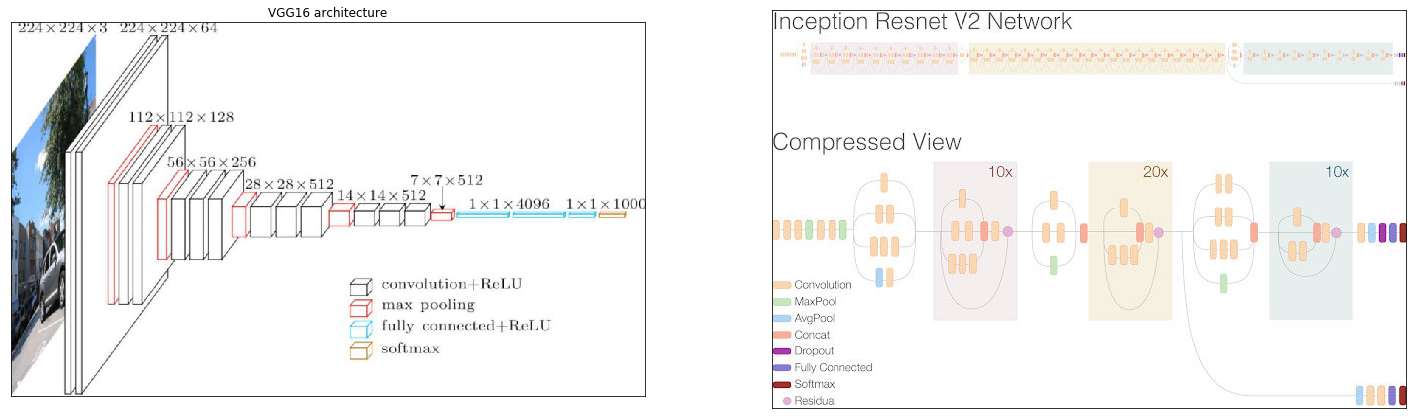

In [5]:
fig = plt.figure(figsize = (25, 25))

ax1 = plt.subplot(1,2,1)
plt.imshow(vgg16)
plt.title('VGG16 architecture')
ax1.set_xticks([])
ax1.set_yticks([])

ax2 = plt.subplot(1, 2, 2)
plt.imshow(inception_resnetv2)
ax2.set_xticks([])
ax2.set_yticks([])

plt.show()

### Global variables

In [6]:
#data path
train_dir = "data/train/"
test_dir = "data/test/"

#data variables
CLASS = "categorical"
COLOR = "rgb"
TARGET_SIZE = (299,299)
BATCH_SIZE = 3

#optimizer variables
SGD_OPT = tf.keras.optimizers.SGD(learning_rate=0.01, decay=0.005, momentum=0.9, nesterov=True)

LOSS = tf.keras.losses.CategoricalCrossentropy()
METRICS = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.AUC()]

REGULARIZER = tf.keras.regularizers.l2(0.0005)

#Create log directory
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")

### Training and testing data preparation

In [7]:
train_generator = ImageDataGenerator(
    rescale=1.0/255., 
    zoom_range=0.1, 
    rotation_range=45, 
    width_shift_range=0.05, 
    height_shift_range=0.05, 
    brightness_range=[0.2,1.0],
    fill_mode='nearest',
    horizontal_flip=True
)

In [8]:
test_generator = ImageDataGenerator(rescale=1.0/255.)

In [9]:
train_data = train_generator.flow_from_directory(
    train_dir,
    target_size = TARGET_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = CLASS,
    color_mode = COLOR
)

Found 196 images belonging to 14 classes.


In [10]:
test_data = test_generator.flow_from_directory(
    test_dir,
    target_size = TARGET_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = CLASS,
    color_mode = COLOR)

Found 84 images belonging to 14 classes.


### Training and testing data preparation for the VGG based models

In [11]:
vgg_test_generator = ImageDataGenerator(preprocessing_function=ppu)

In [12]:
vgg_train_generator = ImageDataGenerator(preprocessing_function=ppu)

In [13]:
vgg_train_data = vgg_train_generator.flow_from_directory(
    train_dir,
    target_size = (224,224),
    batch_size = BATCH_SIZE,
    class_mode = CLASS,
    color_mode = COLOR
)

Found 196 images belonging to 14 classes.


In [14]:
vgg_test_data = vgg_test_generator.flow_from_directory(
    test_dir,
    target_size = (224,224),
    batch_size = BATCH_SIZE,
    class_mode = CLASS,
    color_mode = COLOR
)

Found 84 images belonging to 14 classes.


**Function definitions**

In [15]:
def fit_model(model, data_train, data_validation, num_epochs):
    '''Fits the training and validation data to the model for a given number of epochs'''
    history = model.fit(data_train, 
                           steps_per_epoch = data_train.samples/BATCH_SIZE, epochs=num_epochs,
                           validation_data=data_validation,
                          callbacks=[TensorBoard(log_dir=log_dir, histogram_freq=1)])
    return history

In [16]:
def plot_train_curve (history):
    '''Plots the learning curves for train and validation data from the model history'''
    #accuracy subplot
    fig = plt.figure(figsize=(5, 8))
    ax1 = fig.add_subplot(2, 1, 1)
    ax1.plot(history.history['categorical_accuracy'])
    ax1.plot(history.history['val_categorical_accuracy'])
    ax1.set_title('Model accuracy')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('accuracy')
    ax1.legend(['train', 'validation'], loc='upper left')

    # area under the curve subplot
    ax2 = fig.add_subplot(2, 1, 2)
    ax2.plot(history.history['auc'])
    ax2.plot(history.history['val_auc'])
    ax2.set_title('Model AUC')
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('auc')
    ax2.legend(['train', 'validation'], loc='upper left')

    plt.subplots_adjust(hspace=0.3)
    plt.show()

In [17]:
def confusion_matrix(model, data, num_classes):
    '''Prints confusion matrix for the given model'''
    
    predicted_classes = model.predict_classes(data)
    true_classes = data.classes
    cm = tf.math.confusion_matrix(labels=true_classes, predictions=predicted_classes, num_classes=num_classes).numpy()
    
    #normalize matrix data
    cm_norm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    
    #plots the confusion matrix
    f, ax = plt.subplots(figsize = (9,8))
    sns.heatmap(cm_norm, annot = True, linewidths = 0.5, ax = ax)

    #fixing first and last row of the matrix as they are cut in half
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.show()

In [18]:
def predict_image(my_model, file_location, preprocessing, target_size):
    '''Prepares an image from file location for classification by a trained model and returns the image and the predicted class with the probability'''
    
    image = load_img(file_location, target_size=target_size)

    #show the image
    imgplot = plt.imshow(image)
    plt.show()

    #preapre the image for the trained model
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocessing (image)

    # predict the probability that the image pertains to a certain class
    prediction = my_model.predict(image)
    print(prediction)
    probability = np.max(prediction)
    bird = list(train_data.class_indices.keys())[list(train_data.class_indices.values()).index(np.argmax(prediction))]
    print("The photo contains {0} with probability {1}.".format(bird, probability))

In [19]:
def predict_image_batch (model, folder, preprocessing, target_size):
    '''plot and predict class for more than one images in a given folder'''
    
    for file in glob.iglob(folder + '**/*.jpg', recursive=True):
        predict_image(model, file, preprocessing, target_size)
    

### Simple convolutional architecture

The input shape for the images is reduced to 299x299 or 224x224 due to low GPU memory, and to be consistent with the size of ImageNet pictures respectively. The convolutional layers are stacked similarly to those in the VGG architecture in order to reduce the number of trainable parameters. The filter size and strides are small, and the padding used is ‘same’, which aims to retain more pixel information from the original images. When added, the BatchNormalization layer fights the internal covariate shift in deeper neural networks as it standardizes the inputs to a layer for each mini-batch which also stabilizes the learning process and thus may lead to reduced number of the epochs necessary for training [8]. Dropout layer is not added, because the BatchNormalization also helps with model generalization. Activation is set to ReLU in order to manage the ‘vanishing gradients’ problem. For the same reason, the learning rate is set to one order below the default and the weights initialization is set to the default Glorot uniform initializer.

In [20]:
simple_model = Sequential([
    Input(shape=(299,299,3)),
    Conv2D(32, 3, strides=1, padding = "same", activation='relu'),
    Conv2D(32, 3, strides=1, padding = "same", activation='relu'),
    Conv2D(32, 3, strides=1, padding = "same", activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same'),
    Conv2D(64, 3, strides=1, padding = "same", activation='relu'),
    Conv2D(64, 3, strides=1, padding = "same", activation='relu'),
    Conv2D(64, 3, strides=1, padding = "same", activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2), strides=(2,2),padding='same'),
#     Dropout(0.05), reaches higher accuracy without dropout
    Conv2D(128, 3, strides=1, padding = "same", activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same'),
    Flatten(),
    Dense(14, activation='softmax')
])

In [21]:
simple_model.compile(optimizer=Adam(learning_rate=0.0001), loss=LOSS, metrics=METRICS)

In [22]:
simple_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 299, 299, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 299, 299, 32)      9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 299, 299, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 150, 150, 64)      18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 150, 150, 64)      36928     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 150, 150, 64)      3

In [23]:
simple_history = fit_model(simple_model, train_data, test_data, 42)

Epoch 1/42
66/65 [==============================] - 34s 512ms/step - loss: 2.7801 - categorical_accuracy: 0.0510 - auc: 0.5012 - val_loss: 2.6367 - val_categorical_accuracy: 0.1429 - val_auc: 0.5041
Epoch 2/42
66/65 [==============================] - 35s 523ms/step - loss: 2.5899 - categorical_accuracy: 0.1173 - auc: 0.5843 - val_loss: 2.6229 - val_categorical_accuracy: 0.1429 - val_auc: 0.6223
Epoch 3/42
66/65 [==============================] - 36s 549ms/step - loss: 2.3285 - categorical_accuracy: 0.2398 - auc: 0.7349 - val_loss: 2.5172 - val_categorical_accuracy: 0.2857 - val_auc: 0.7712
Epoch 4/42
66/65 [==============================] - 36s 551ms/step - loss: 2.2922 - categorical_accuracy: 0.2347 - auc: 0.7522 - val_loss: 2.5642 - val_categorical_accuracy: 0.2500 - val_auc: 0.7282
Epoch 5/42
66/65 [==============================] - 36s 542ms/step - loss: 2.1339 - categorical_accuracy: 0.3214 - auc: 0.8007 - val_loss: 2.4709 - val_categorical_accuracy: 0.2262 - val_auc: 0.7204
Epoch

66/65 [==============================] - 37s 564ms/step - loss: 0.6776 - categorical_accuracy: 0.7959 - auc: 0.9776 - val_loss: 1.0698 - val_categorical_accuracy: 0.7381 - val_auc: 0.9533


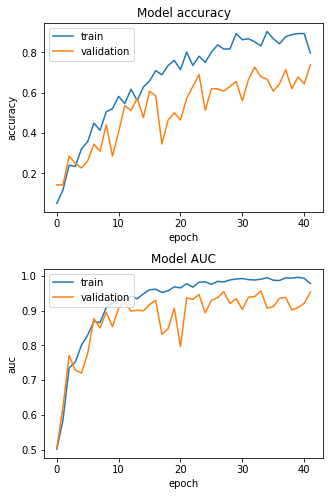

In [24]:
plot_train_curve(simple_history)

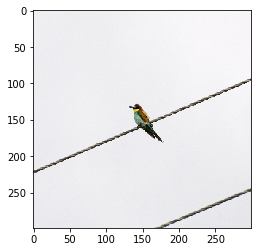

[[7.5295973e-03 3.8557287e-19 2.1346996e-15 5.0384085e-12 5.1328474e-30
  1.7303154e-08 5.7480391e-03 1.9397251e-12 7.9039142e-23 2.4223837e-16
  3.8944751e-18 9.8406315e-01 2.6591567e-03 3.5548325e-17]]
The photo contains Oenanthe pleschanka with probability 0.9840631484985352.


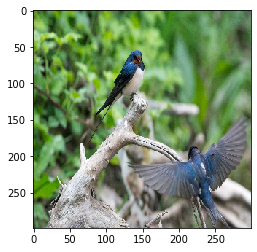

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
The photo contains Parus major with probability 1.0.


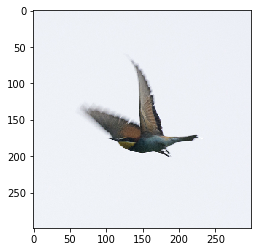

[[9.98407066e-01 1.66200108e-38 2.53631273e-35 0.00000000e+00
  0.00000000e+00 8.45395336e-19 9.37704030e-08 3.70670495e-14
  1.11658705e-35 2.60587161e-31 1.03725274e-30 1.59281888e-03
  2.79667859e-20 1.10917834e-29]]
The photo contains Alcedo atthis with probability 0.9984070658683777.


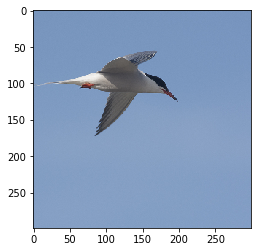

[[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 9.3683663e-38 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 1.0000000e+00 0.0000000e+00]]
The photo contains Parus major with probability 1.0.


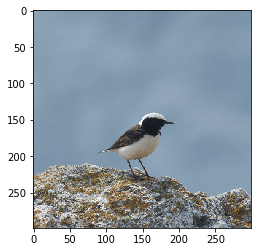

[[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  5.6032438e-38 8.3993166e-07 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 9.9999917e-01 0.0000000e+00]]
The photo contains Parus major with probability 0.9999991655349731.


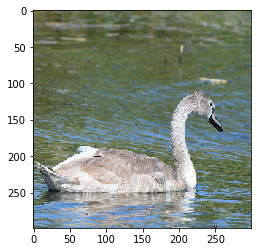

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
The photo contains Parus major with probability 1.0.


In [25]:
predict_image_batch(simple_model, 'data/predict', preprocess_input, (299,299))

### VGG16 architecture implementation from scratch

This model is completely identical to the original VGG16 architecture and aims to investigate how the naive architecture performs on this small dataset in comparison to results achieved by the pretrained model.

In [26]:
vgg = VGG16(include_top=False, pooling='avg', input_shape=(224, 224, 3))
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [27]:
vgg_twin = Sequential([
    Input(shape=(299, 299, 3)),
    Conv2D(64, (3, 3), padding= 'same'),
    LeakyReLU(alpha = 0.2),
    Conv2D(64, (3, 3), padding= 'same'),
    LeakyReLU(alpha = 0.2),
    MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    Conv2D(128, (3, 3), padding= 'same'),
    LeakyReLU(alpha = 0.2),
    Conv2D(128, (3, 3), padding= 'same'),
    LeakyReLU(alpha = 0.2),
    MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    Conv2D(256, (3, 3), padding= 'same'),
    LeakyReLU(alpha = 0.2),
    Conv2D(256, (3, 3), padding= 'same'),
    LeakyReLU(alpha = 0.2),
    Conv2D(256, (3, 3), padding= 'same'),
    LeakyReLU(alpha = 0.2),
    MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    Conv2D(512, (3, 3), padding= 'same'),
    LeakyReLU(alpha = 0.2),
    Conv2D(512, (3, 3), padding= 'same'),
    LeakyReLU(alpha = 0.2),
    Conv2D(512, (3, 3), padding= 'same'),
    LeakyReLU(alpha = 0.2),
    MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    Conv2D(512, (3, 3), padding= 'same'),
    LeakyReLU(alpha = 0.2),
    Conv2D(512, (3, 3), padding= 'same'),
    LeakyReLU(alpha = 0.2),
    Conv2D(512, (3, 3), padding= 'same'),
    LeakyReLU(alpha = 0.2),
    MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    Flatten(),
    Dense(25, activation= 'relu'),
    Dense(25, activation= 'relu'),
    Dense(14, activation= 'softmax')
    ])

In [28]:
vgg_twin.compile(optimizer=Adam(), loss=LOSS, metrics=METRICS)

In [29]:
vgg_twin_history = fit_model(vgg_twin, train_data, test_data, 15)


Epoch 1/15
66/65 [==============================] - 153s 2s/step - loss: 24.3400 - categorical_accuracy: 0.2500 - auc: 0.6753 - val_loss: 2.6391 - val_categorical_accuracy: 0.0714 - val_auc: 0.5000
Epoch 2/15
66/65 [==============================] - 141s 2s/step - loss: 2.6400 - categorical_accuracy: 0.0561 - auc: 0.5000 - val_loss: 2.6391 - val_categorical_accuracy: 0.0714 - val_auc: 0.5000
Epoch 3/15
66/65 [==============================] - 142s 2s/step - loss: 2.6398 - categorical_accuracy: 0.0459 - auc: 0.5000 - val_loss: 2.6391 - val_categorical_accuracy: 0.0714 - val_auc: 0.5000
Epoch 4/15
66/65 [==============================] - 142s 2s/step - loss: 2.6399 - categorical_accuracy: 0.0663 - auc: 0.4880 - val_loss: 2.6391 - val_categorical_accuracy: 0.0714 - val_auc: 0.5000
Epoch 5/15
66/65 [==============================] - 141s 2s/step - loss: 2.6398 - categorical_accuracy: 0.0714 - auc: 0.4941 - val_loss: 2.6391 - val_categorical_accuracy: 0.0714 - val_auc: 0.5000
Epoch 6/15
66/

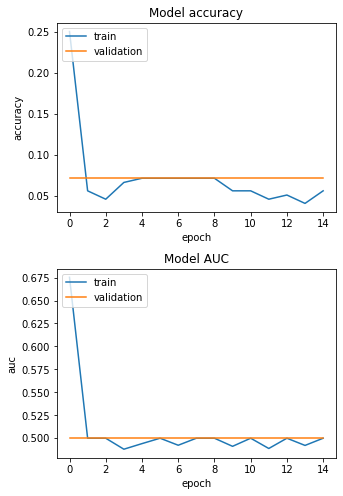

In [30]:
plot_train_curve(vgg_twin_history)

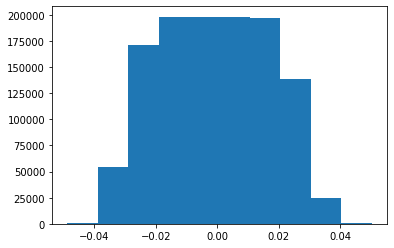

In [31]:
plt.hist(vgg_twin.layers[17].kernel.numpy().ravel())
plt.show()

### Transfer learning using VGG16

This model uses the feature extraction (convolutional) part of the VGG16 architecture with weights trained on the ImageNet dataset frozen. The classification part is replaced with the appropriate Dense layer for classification of 14 classes.

In [32]:
transfer_model_vgg = Sequential()
transfer_model_vgg.add(vgg)
transfer_model_vgg.add(Dense(14, activation='softmax'))
transfer_model_vgg.layers[0].trainable = False
transfer_model_vgg.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
dense_4 (Dense)              (None, 14)                7182      
Total params: 14,721,870
Trainable params: 7,182
Non-trainable params: 14,714,688
_________________________________________________________________


In [33]:
transfer_model_vgg.compile(optimizer=Adam(), loss=LOSS, metrics=METRICS)

In [34]:
transfer_vgg_history = fit_model(transfer_model_vgg, vgg_train_data, vgg_test_data, 42)

Epoch 1/42
66/65 [==============================] - 39s 587ms/step - loss: 6.3163 - categorical_accuracy: 0.1500 - auc: 0.5918 - val_loss: 3.3388 - val_categorical_accuracy: 0.4167 - val_auc: 0.7906
Epoch 2/42
66/65 [==============================] - 33s 494ms/step - loss: 1.7368 - categorical_accuracy: 0.5918 - auc: 0.9020 - val_loss: 1.4795 - val_categorical_accuracy: 0.7024 - val_auc: 0.9138
Epoch 3/42
66/65 [==============================] - 33s 501ms/step - loss: 0.6990 - categorical_accuracy: 0.8061 - auc: 0.9696 - val_loss: 0.8735 - val_categorical_accuracy: 0.8095 - val_auc: 0.9621
Epoch 4/42
66/65 [==============================] - 32s 490ms/step - loss: 0.2997 - categorical_accuracy: 0.9235 - auc: 0.9918 - val_loss: 0.6069 - val_categorical_accuracy: 0.8333 - val_auc: 0.9796
Epoch 5/42
66/65 [==============================] - 32s 491ms/step - loss: 0.1695 - categorical_accuracy: 0.9694 - auc: 0.9964 - val_loss: 0.4921 - val_categorical_accuracy: 0.8571 - val_auc: 0.9880
Epoch

66/65 [==============================] - 33s 496ms/step - loss: 0.0014 - categorical_accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.2460 - val_categorical_accuracy: 0.9286 - val_auc: 0.9927


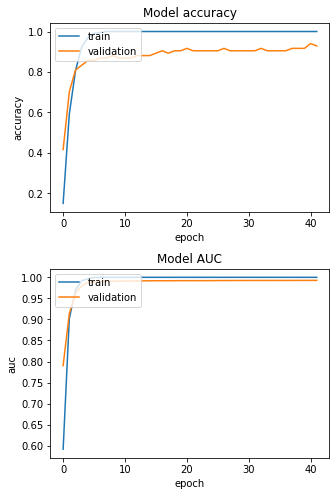

In [35]:
plot_train_curve(transfer_vgg_history)

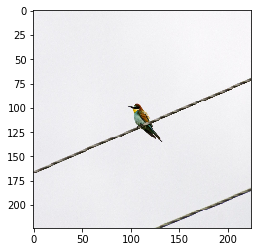

[[6.3383847e-02 6.1282812e-04 1.3497052e-07 1.2765432e-04 7.4034588e-08
  6.6733134e-07 7.6855689e-01 1.4337090e-04 1.3846917e-06 4.5934357e-02
  6.4853230e-05 1.0658943e-02 1.0136876e-01 9.1461996e-03]]
The photo contains Hirundo rustica with probability 0.7685568928718567.


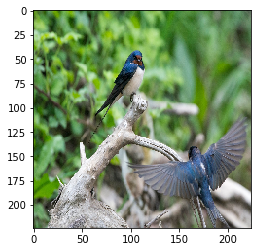

[[1.64460227e-01 7.97341199e-05 2.49732039e-08 3.57734216e-08
  5.77035308e-08 2.60807034e-02 1.51447859e-03 1.46262182e-05
  6.25370204e-01 1.20414935e-01 3.58846073e-08 6.19953871e-02
  5.07572513e-05 1.88899903e-05]]
The photo contains Loxia curvirostra with probability 0.6253702044487.


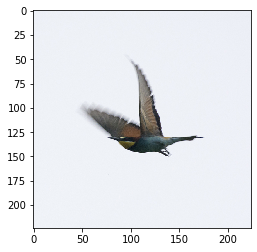

[[2.8445735e-03 9.0239668e-04 6.0492391e-07 3.6613872e-07 6.0390888e-05
  8.7538683e-05 1.6682842e-01 1.0023183e-03 3.3107186e-03 3.4663800e-02
  7.8902614e-01 9.6959434e-07 9.3618100e-06 1.2624428e-03]]
The photo contains Nycticorax nycticorax with probability 0.789026141166687.


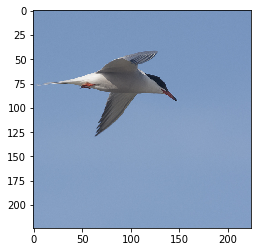

[[3.2736738e-05 9.0804479e-06 3.1534384e-09 2.9224233e-07 9.4430048e-05
  7.1037817e-07 2.7607177e-06 2.5960574e-08 1.3142864e-02 7.4748993e-03
  3.3039986e-03 8.8827175e-05 5.0092936e-08 9.7584939e-01]]
The photo contains Sterna hirundo with probability 0.9758493900299072.


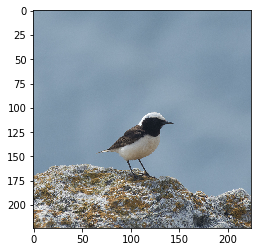

[[2.4549525e-09 7.6704296e-09 2.0822633e-13 7.3213088e-03 1.5195084e-08
  9.8122246e-06 4.9093952e-08 2.0373478e-09 5.2470409e-07 6.7070877e-11
  1.4344598e-09 9.9266350e-01 2.4276283e-06 2.4153842e-06]]
The photo contains Oenanthe pleschanka with probability 0.9926635026931763.


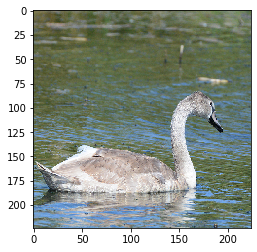

[[5.6916178e-07 1.0670455e-11 1.2099122e-11 4.4505942e-08 9.9991965e-01
  2.2654973e-08 4.7069119e-11 9.0458384e-11 3.1394143e-07 8.3351347e-07
  2.0298558e-09 1.9529862e-10 2.0683380e-15 7.8610428e-05]]
The photo contains Cygnus olor with probability 0.9999196529388428.


In [36]:
predict_image_batch(transfer_model_vgg, 'data/predict', ppu, (224,224))

### Transfer learning with VGG16 with Inception block

Most of the time bird photographs do not have the main object, or so called salient part, placed in the center and occupying the same amount of space of the image. This means that choosing the right kernel size for the convolutional network may become a hard task, and constructing a rather wider than deeper network incorporating an inception module with filters of different sizes that operate on the same level can help [11]. The architecture consists of 2 blocks from the pretrained VGG16 model and an inception block with 3 Convolutional layers with different kernel size.

In [37]:
vgg_outputs = vgg.get_layer('block2_pool').output
batch = BatchNormalization()(vgg_outputs)
pool1 = MaxPool2D((3,3), strides=(1,1), padding='same')(batch)
conv1 = Conv2D(32, 1, padding = "same", activation='relu', kernel_regularizer=REGULARIZER)(pool1)
conv3 = Conv2D(64, 3, padding = "same", activation='relu', kernel_regularizer=REGULARIZER)(pool1)
conv5 = Conv2D(128, 5, padding = "same", activation='relu', kernel_regularizer=REGULARIZER)(pool1)
pool = MaxPool2D(pool_size=(3,3), strides=(1,1), padding='same')(pool1)
layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
flat1 = Flatten()(layer_out)
output = Dense(14, activation='softmax')(flat1)

vgg_inception_model = Model(inputs=vgg.inputs, outputs=output)

In [38]:
for i in range(7):
    vgg_inception_model.layers[i].trainable = False

In [39]:
vgg_inception_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
______________________________________________________________________________________________

In [40]:
vgg_inception_model.compile(optimizer=Adam(learning_rate = 0.00005, clipnorm=1.0), loss=LOSS, metrics=METRICS)

In [41]:
vgg_inception_history = fit_model(vgg_inception_model, vgg_train_data, vgg_test_data, 42)


Epoch 1/42
66/65 [==============================] - 40s 608ms/step - loss: 42.8298 - categorical_accuracy: 0.4107 - auc: 0.7063 - val_loss: 22.9618 - val_categorical_accuracy: 0.4286 - val_auc: 0.7055
Epoch 2/42
66/65 [==============================] - 34s 508ms/step - loss: 13.7976 - categorical_accuracy: 0.6224 - auc: 0.8204 - val_loss: 34.4945 - val_categorical_accuracy: 0.3095 - val_auc: 0.6538
Epoch 3/42
66/65 [==============================] - 33s 498ms/step - loss: 6.7051 - categorical_accuracy: 0.8010 - auc: 0.9087 - val_loss: 25.5889 - val_categorical_accuracy: 0.5238 - val_auc: 0.7543
Epoch 4/42
66/65 [==============================] - 33s 498ms/step - loss: 3.7375 - categorical_accuracy: 0.8622 - auc: 0.9366 - val_loss: 13.5368 - val_categorical_accuracy: 0.6548 - val_auc: 0.8195
Epoch 5/42
66/65 [==============================] - 34s 508ms/step - loss: 1.8568 - categorical_accuracy: 0.9184 - auc: 0.9670 - val_loss: 21.0078 - val_categorical_accuracy: 0.5714 - val_auc: 0.786

Epoch 42/42
66/65 [==============================] - 33s 502ms/step - loss: 0.1036 - categorical_accuracy: 1.0000 - auc: 1.0000 - val_loss: 39.7093 - val_categorical_accuracy: 0.6548 - val_auc: 0.8193


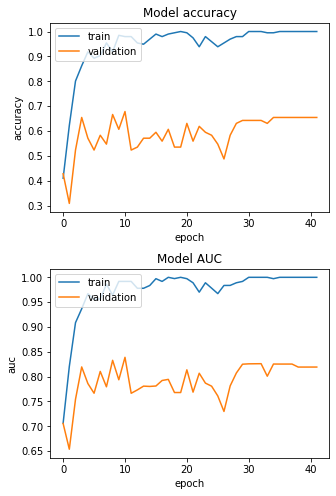

In [42]:
plot_train_curve(vgg_inception_history)

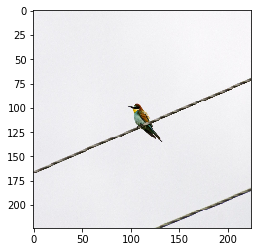

[[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 1.6932375e-14 5.0857484e-37
  2.1243372e-15 0.0000000e+00 0.0000000e+00 1.0000000e+00]]
The photo contains Sterna hirundo with probability 1.0.


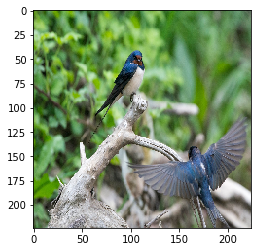

[[1.3029057e-37 5.2841669e-03 0.0000000e+00 0.0000000e+00 0.0000000e+00
  8.1015974e-01 1.8455599e-01 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]]
The photo contains Garrulus glandarius with probability 0.8101597428321838.


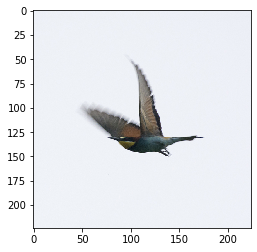

[[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 1.3661630e-26 0.0000000e+00 0.0000000e+00 0.0000000e+00
  1.0000000e+00 0.0000000e+00 0.0000000e+00 2.8011736e-12]]
The photo contains Nycticorax nycticorax with probability 1.0.


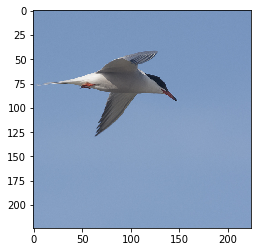

[[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 1.3242347e-29 0.0000000e+00 0.0000000e+00 0.0000000e+00
  6.5992882e-32 0.0000000e+00 0.0000000e+00 1.0000000e+00]]
The photo contains Sterna hirundo with probability 1.0.


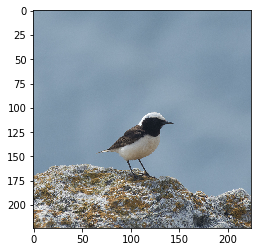

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
The photo contains Oenanthe pleschanka with probability 1.0.


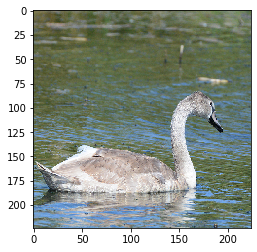

[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
The photo contains Cygnus olor with probability 1.0.


In [43]:
predict_image_batch(vgg_inception_model, 'data/predict', ppu, (224,224))

In [44]:
vgg_inception_model.layers

In [45]:
vgg_inception_model.layers[9].weights

[<tf.Variable 'conv2d_20/kernel:0' shape=(1, 1, 128, 32) dtype=float32, numpy=
 array([[[[-0.14320458, -0.16597062,  0.16964272, ...,  0.01835235,
            0.15822342, -0.08593703],
          [ 0.1261105 , -0.12146002,  0.15187424, ..., -0.03724833,
           -0.02402258,  0.04318026],
          [ 0.0851264 ,  0.03790151, -0.07903726, ...,  0.12652938,
            0.01785535, -0.18985374],
          ...,
          [-0.06683464,  0.00416731, -0.08959038, ...,  0.03036188,
            0.10257526, -0.07581022],
          [ 0.15602909, -0.11683237,  0.15652956, ...,  0.07251358,
            0.16202313,  0.18106592],
          [ 0.07927775, -0.12038261,  0.1674668 , ..., -0.03109841,
            0.10367619, -0.09938523]]]], dtype=float32)>,
 <tf.Variable 'conv2d_20/bias:0' shape=(32,) dtype=float32, numpy=
 array([-0.00156012,  0.00499841, -0.00293078, -0.01175019, -0.01275304,
         0.00058817, -0.00648029, -0.00346867, -0.00772207, -0.00338158,
        -0.00089162, -0.00148937, -0.

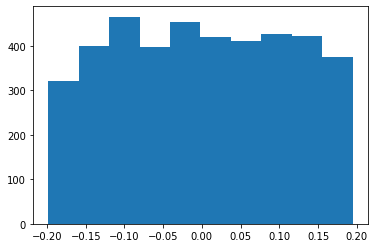

In [46]:
plt.hist(vgg_inception_model.layers[9].kernel.numpy().ravel())
plt.show()

### Transfer learning with Inception-ResNet-V2


This is a convolutional neural network also trained on the images from the ImageNet database. It contains 164 layers and classifies up to 1000 categories. Here the classification part is replaced with a Dense layer for the 14 bird species. The image input size is a little larger, 299x299, compared to 224x224 in VGG.

In [48]:
inception_model = InceptionResNetV2(include_top=False, input_shape=(299, 299, 3), pooling='avg')

In [49]:
inception_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 149, 149, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 149, 149, 32) 96          conv2d_23[0][0]                  
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization_2[0][0]      
________________________________________________________________________________

batch_normalization_186 (BatchN (None, 8, 8, 192)    576         conv2d_207[0][0]                 
__________________________________________________________________________________________________
activation_184 (Activation)     (None, 8, 8, 192)    0           batch_normalization_186[0][0]    
__________________________________________________________________________________________________
conv2d_208 (Conv2D)             (None, 8, 8, 224)    129024      activation_184[0][0]             
__________________________________________________________________________________________________
batch_normalization_187 (BatchN (None, 8, 8, 224)    672         conv2d_208[0][0]                 
__________________________________________________________________________________________________
activation_185 (Activation)     (None, 8, 8, 224)    0           batch_normalization_187[0][0]    
__________________________________________________________________________________________________
conv2d_206

In [50]:
inception_transfer_model = Sequential()
inception_transfer_model.add(inception_model)
inception_transfer_model.add(Dense(14, activation='softmax'))
inception_transfer_model.layers[0].trainable = False
inception_transfer_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 1536)              54336736  
_________________________________________________________________
dense_6 (Dense)              (None, 14)                21518     
Total params: 54,358,254
Trainable params: 21,518
Non-trainable params: 54,336,736
_________________________________________________________________


In [51]:
inception_transfer_model.compile(optimizer=Adam(), loss=LOSS, metrics=METRICS)

In [52]:
inception_transfer_history = fit_model(inception_transfer_model, train_data, test_data, 42)

Epoch 1/42
66/65 [==============================] - 79s 1s/step - loss: 1.8704 - categorical_accuracy: 0.5071 - auc: 0.8331 - val_loss: 0.9860 - val_categorical_accuracy: 0.7262 - val_auc: 0.9771
Epoch 2/42
66/65 [==============================] - 65s 979ms/step - loss: 0.7444 - categorical_accuracy: 0.8265 - auc: 0.9838 - val_loss: 0.5694 - val_categorical_accuracy: 0.8214 - val_auc: 0.9932
Epoch 3/42
66/65 [==============================] - 65s 985ms/step - loss: 0.5361 - categorical_accuracy: 0.8929 - auc: 0.9941 - val_loss: 0.4809 - val_categorical_accuracy: 0.8929 - val_auc: 0.9946
Epoch 4/42
66/65 [==============================] - 65s 980ms/step - loss: 0.4156 - categorical_accuracy: 0.8980 - auc: 0.9955 - val_loss: 0.4097 - val_categorical_accuracy: 0.8810 - val_auc: 0.9953
Epoch 5/42
66/65 [==============================] - 65s 989ms/step - loss: 0.3309 - categorical_accuracy: 0.9082 - auc: 0.9975 - val_loss: 0.3298 - val_categorical_accuracy: 0.8929 - val_auc: 0.9972
Epoch 6/

Epoch 41/42
66/65 [==============================] - 65s 992ms/step - loss: 0.0256 - categorical_accuracy: 0.9949 - auc: 1.0000 - val_loss: 0.0789 - val_categorical_accuracy: 0.9881 - val_auc: 0.9999
Epoch 42/42
66/65 [==============================] - 65s 991ms/step - loss: 0.0426 - categorical_accuracy: 0.9949 - auc: 1.0000 - val_loss: 0.1298 - val_categorical_accuracy: 0.9524 - val_auc: 0.9996


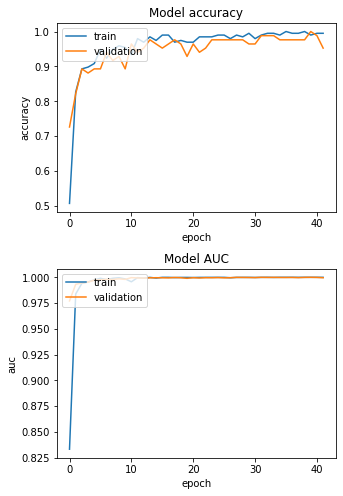

In [53]:
plot_train_curve(inception_transfer_history)

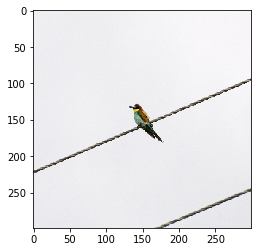

[[7.8872023e-03 2.4480130e-06 3.4666293e-06 1.8424031e-05 3.5265373e-06
  1.7720517e-05 4.4933349e-04 2.3420712e-06 2.6834931e-03 9.8819774e-01
  1.0225367e-05 1.5186243e-05 6.9679430e-04 1.2042718e-05]]
The photo contains Merops apiaster with probability 0.9881977438926697.


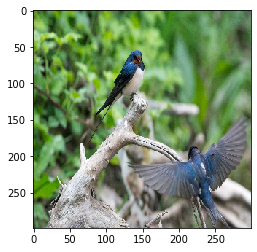

[[3.7614182e-01 1.2423001e-06 1.4834603e-06 7.8182859e-07 1.1525580e-06
  1.2531641e-03 6.1749619e-01 4.2702132e-04 2.4785607e-03 7.3021307e-05
  2.7304185e-07 1.5617029e-03 5.6330813e-04 2.4577292e-07]]
The photo contains Hirundo rustica with probability 0.6174961924552917.


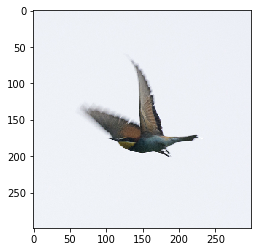

[[1.1359727e-03 1.9328179e-07 2.8468651e-07 4.1649905e-06 2.8571533e-06
  2.3894274e-06 1.3853790e-04 4.5048398e-07 1.4917739e-03 9.9713767e-01
  4.3044897e-06 2.6818593e-06 7.4064374e-05 4.6819005e-06]]
The photo contains Merops apiaster with probability 0.9971376657485962.


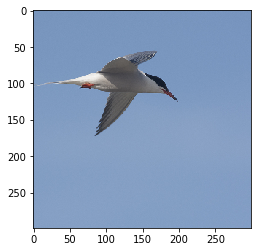

[[1.8850891e-05 1.9356981e-05 3.5735418e-08 8.8723273e-06 3.3270911e-04
  1.7000647e-07 1.0932885e-06 8.7160352e-06 2.7781436e-05 6.1092796e-05
  5.8348209e-04 1.8930078e-03 8.6647708e-07 9.9704391e-01]]
The photo contains Sterna hirundo with probability 0.9970439076423645.


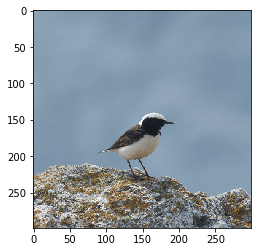

[[1.0298809e-07 9.8871726e-07 2.2639366e-08 1.1495521e-03 5.6607382e-07
  1.4742307e-05 8.5133361e-06 3.1829572e-05 7.1031532e-06 2.2295572e-07
  7.1441080e-09 9.9810129e-01 1.1837092e-07 6.8491476e-04]]
The photo contains Oenanthe pleschanka with probability 0.9981012940406799.


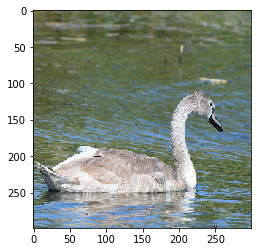

[[1.5368003e-05 3.1146999e-05 6.8332715e-06 4.3695691e-05 9.9396849e-01
  5.4456276e-04 6.6495617e-05 1.7811909e-04 5.8464826e-05 2.9889445e-04
  5.9475973e-05 3.5083512e-04 3.4452267e-05 4.3431609e-03]]
The photo contains Cygnus olor with probability 0.9939684867858887.


In [54]:
predict_image_batch(inception_transfer_model, 'data/predict', preprocess_input, (299,299))

### Results and discussion

*Simple model* - It is expected that this model will have low accuracy and it reaches higher training and validation accuracy than expected; however it fails to generalize and to predict the bird classes correctly.<br>

*VGG-twin* - The VGG architecture seems inappropriate for a dataset with such a small size. If there is a vanishing gradients problem, a change in activation to leaky relu would help, but it seems that the model is not learning at all. Investigation of the weights showed that they do not change their distribution from uniform to normal and look like a random noise. Change in optimizer to SGD with learning rate decay and to a smaller learning rate does not lead to any improvement.<br>

*Transfer model VGG* - The weights plotted on the Tensorboard Histograms window for the Dense layer, which has trainable parameters, show that there is change in the weights’ distribution over epochs. This means that the model is learning which is also demonstrated by the learning curve. The VGG model reaches very high accuracy on the validation set and when tested on square images of birds, manages to classify them correctly with a probability of over 95 percent; however, when being tested with sample images that are stretched during image resize, it fails to recognize the bird on the photograph for all of them. <br>

*VGG model with inception block* - First attempts for training this model showed huge variations not only in the validation, but in the training loss. This is somehow expected having in mind the large number of trainable parameters and the small size of the dataset. In order to stabilize the model loss, regularization parameter l2 was added to the Convolutional layers. Both l2 and l2 regularization parameters alone or in combination were used, but l2 yielded better results. As sudden peaks of training loss were also observed (most probably due to exploding gradients), clipnorm parameter was added to the Adam optimizer. Although the validation accuracy does not exceed 70%, the model manages to predict the classes for all test bird images (with probability of 1, which is unexpected); however fails to predict most of the images that are stretched or shrunk when resized. The model clearly shows overfitting. Applyng batch normalization after the flatten layer led to drop in accuracy for the training data after the 10th epoch. <br>

*Inception-ResNet-V2* - This model achieves the highest results and manages to correctly recognize the photographed bird with a confidence higher than 90 percent (except for the swallow photo). Actually it was possible to train the model with images of larger size 800x800 pixels in Google Colab, where it makes correct predictions with probability of 0.99 to 1. 

### Further work

Further work in the direction of this project would implicate adding more classes of bird species. Additionally the VGG twin and the simple model could be trained on a bigger dataset in order to investigate more thoroughly the reasons for the fair performance of these models on the proposed dataset. Additional exploration of the reasons for overfitting of the training data by the VGG model with Inception block is also expected to give some insights.

### Conclusion

From the results obtained in this project, it can be concluded that the Inception network with residual blocks provides the best results and performance managing to correctly recognize all of the birds on the test images with probability higher than 90 percent no matter if they are skewed during resizing. The next best model is the VGG16 transfer model which however does not achieve the results obtained by Inception-ResNet based model. The convolutional network that resembles VGG16 gets stuck from the first epochs and does not manage to learn from the dataset so VGG16 architecture on its own is not suitable for being trained on a small dataset. The simple convolutional model archives better training results but fails on the test data. The model which contains a feature extraction part with frozen weights from the VGG16 network overfits heavily the training data and has controversial success recognizing the correct bird species, especially when the photos are stretched. Most probably further work with the latter will lead to better performance.

### Resurces

1. https://arxiv.org/pdf/1810.04250v2.pdf
2. https://medium.com/starschema-blog/transfer-learning-the-dos-and-donts-165729d66625
3. http://www.aimsciences.org/article/doi/10.3934/mfc.2018008
4. https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
5. https://arxiv.org/abs/1409.1556
6. https://www.researchgate.net/publication/327070011_Accelerating_Deep_Neural_Networks_on_Low_Power_Heterogeneous_Architectures
7. https://arxiv.org/pdf/1602.07261v2.pdf
8. https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/
9. https://arxiv.org/ftp/arxiv/papers/1809/1809.09529.pdf
10. https://github.com/venkateshprasad23/Bird-Classification-using-Transfer-Learning/blob/master/bird.ipynb
11. https://towardsdatascience.com/a-simple-guide-to-the-versions-of-the-inception-network-7fc52b863202

